# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def gaussian(x, derivative=False):
    if derivative:
        return -2*x*np.exp(-x**2)
    return np.exp(-x**2)

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def sigmoid_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred)
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(2.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

###### Dos Pesos

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = np.where(weights < 0, -1, weights)
        return np.where(weights > 0, 1, weights)
    return np.sum(np.abs(weights))

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Learning Rate Decay

In [9]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Implementação 

In [10]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.is_trainable = is_trainable
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)  # batch normalization params

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, input_dim), ones(1, input_dim)
        self._bn_cache = None
        self._dropout_mask = None

    def batchnorm_forward(self, x, is_training=True):
        mu = np.mean(x, axis=0) if is_training else self._pop_mean
        var = np.var(x, axis=0) if is_training else self._pop_var
        x_norm = (x - mu) / np.sqrt(var + 1e-8)
        out = self.gamma * x_norm + self.beta

        if is_training:
            self._pop_mean = self.bn_decay * self._pop_mean + (1.0-self.bn_decay)*mu
            self._pop_var = self.bn_decay * self._pop_var + (1.0-self.bn_decay)*var
            self._bn_cache = (x, x_norm, mu, var)
        return out

    def batchnorm_backward(self, dactivation):
        x, x_norm, mu, var = self._bn_cache
        
        m = self._activ_inp.shape[0]
        x_mu = x - mu
        std_inv = 1. / np.sqrt(var + 1e-8)

        dx_norm = dactivation * self.gamma
        dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
        dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

        dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
        self._dgamma = np.sum(dactivation * x_norm, axis=0)
        self._dbeta = np.sum(dactivation, axis=0)
        return dx

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf

    def fit(self, x_train, y_train, x_val=None, y_val=None, batch_size=None, epochs=100, verbose=10):
        batch_size = x_train.shape[0] if batch_size is None else batch_size
        n_batches = x_train.shape[0] // batch_size
        x_val, y_val = (x_train, y_train) if x_val is None or y_val is None else (x_val, y_val)

        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            for batch in range(n_batches):
                offset = batch_size * batch
                x_batch, y_batch = x_train[offset:offset+batch_size], y_train[offset:offset+batch_size]

                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)

            data_loss_val = self.cost_func(y_val, self.predict(x_val))
            if data_loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, data_loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return

            if epoch % verbose == 0:
                data_loss_train = self.cost_func(y_train, self.predict(x_train))
                reg_loss = np.sum([layer.reg_strength*layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, data_loss_train, reg_loss, data_loss_train + reg_loss, data_loss_val))

    def predict(self, x):
        return self.__feedforward(x, is_training=False)

    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = current_layer.batchnorm_forward(y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0-current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out

    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = layer.batchnorm_backward(dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)

        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + layer.reg_strength*layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta
                    continue
                layer.biases = layer.biases - self.learning_rate*layer._dbiases # o bias é ignorado quando a BN é aplicada

# Testes da Implementação

# Early Stopping 

In [11]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

x, y = make_regression(n_samples=100, n_features=1, n_informative=2, noise=10.0, random_state=42)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, patience=10)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x_train, y_train, x_val=x_test, y_val=y_test, epochs=1000, verbose=100)

epoch:    0/1000 loss_train: 1527.05124492 + 0.00000000 = 1527.05124492 loss_val = 1601.65198643
epoch:  100/1000 loss_train: 70.48894440 + 0.00000000 = 70.48894440 loss_val = 104.22230044
epoch:  200/1000 loss_train: 70.46429411 + 0.00000000 = 70.46429411 loss_val = 103.47695019
epoch:  300/1000 loss_train: 70.46429351 + 0.00000000 = 70.46429351 loss_val = 103.47304646
epoch:  400/1000 loss_train: 70.46429351 + 0.00000000 = 70.46429351 loss_val = 103.47302693
epoch:  500/1000 loss_train: 70.46429351 + 0.00000000 = 70.46429351 loss_val = 103.47302683
epoch:  600/1000 loss_train: 70.46429351 + 0.00000000 = 70.46429351 loss_val = 103.47302683
not improving! [1] current: 103.47302683438826 best: 103.47302683438825
not improving! [1] current: 103.47302683438811 best: 103.47302683438811
not improving! [1] current: 103.47302683438804 best: 103.47302683438804
not improving! [1] current: 103.47302683438794 best: 103.47302683438794
not improving! [1] current: 103.47302683438792 best: 103.473026

## Exemplos do Notebook da Intuição

### Exemplo 1

In [10]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.28047145 + 0.00000000 = 0.28047145 loss_val = 0.28047145
[[ 0.14978072  0.19956143]
 [ 0.24975114  0.29950229]]
[[ 0.35891648  0.40866619]
 [ 0.51130127  0.56137012]]


### Exemplo 2

In [11]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val = 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val = 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val = 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val = 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val = 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val = 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val = 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val = 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val = 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val = 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val = 0.06828531
[[ 0.10083595  0.2016719   0.30585165]
 [ 0

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [12]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [13]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 1.0


epoch:    0/1000 loss_train: 4632.17771434 + 0.00000000 = 4632.17771434 loss_val = 4632.17771434
epoch:  100/1000 loss_train: 31.33878504 + 0.00000000 = 31.33878504 loss_val = 31.33878504
epoch:  200/1000 loss_train: 26.20637721 + 0.00000000 = 26.20637721 loss_val = 26.20637721
epoch:  300/1000 loss_train: 26.08843879 + 0.00000000 = 26.08843879 loss_val = 26.08843879
epoch:  400/1000 loss_train: 26.08605969 + 0.00000000 = 26.08605969 loss_val = 26.08605969
epoch:  500/1000 loss_train: 26.08606356 + 0.00000000 = 26.08606356 loss_val = 26.08606356
epoch:  600/1000 loss_train: 26.08607280 + 0.00000000 = 26.08607280 loss_val = 26.08607280
epoch:  700/1000 loss_train: 26.08607442 + 0.00000000 = 26.08607442 loss_val = 26.08607442
epoch:  800/1000 loss_train: 26.08607467 + 0.00000000 = 26.08607467 loss_val = 26.08607467
epoch:  900/1000 loss_train: 26.08607471 + 0.00000000 = 26.08607471 loss_val = 26.08607471
epoch: 1000/1000 loss_train: 26.08607471 + 0.00000000 = 26.08607471 loss_val = 26.08

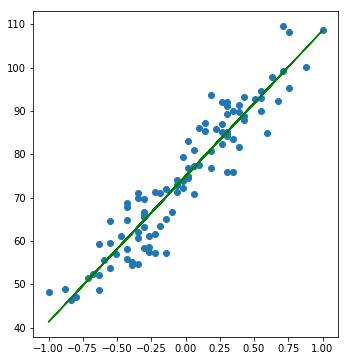

In [14]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, batch_size=10, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [15]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [16]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [ 1.  1.  1.]


In [17]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 12292.69865466 + 0.00000000 = 12292.69865466 loss_val = 12292.69865466
epoch:  200/2000 loss_train: 6.90717546 + 0.00000000 = 6.90717546 loss_val = 6.90717546
epoch:  400/2000 loss_train: 5.82982944 + 0.00000000 = 5.82982944 loss_val = 5.82982944
epoch:  600/2000 loss_train: 5.74832132 + 0.00000000 = 5.74832132 loss_val = 5.74832132
epoch:  800/2000 loss_train: 5.73913854 + 0.00000000 = 5.73913854 loss_val = 5.73913854
epoch: 1000/2000 loss_train: 5.73797930 + 0.00000000 = 5.73797930 loss_val = 5.73797930
epoch: 1200/2000 loss_train: 5.73782949 + 0.00000000 = 5.73782949 loss_val = 5.73782949
epoch: 1400/2000 loss_train: 5.73781005 + 0.00000000 = 5.73781005 loss_val = 5.73781005
epoch: 1600/2000 loss_train: 5.73780752 + 0.00000000 = 5.73780752 loss_val = 5.73780752
epoch: 1800/2000 loss_train: 5.73780719 + 0.00000000 = 5.73780719 loss_val = 5.73780719
epoch: 2000/2000 loss_train: 5.73780715 + 0.00000000 = 5.73780715 loss_val = 5.73780715
[[  8.72093339  14.1

### Regressão Quadrática

In [18]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [19]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 loss_train: 2042.38394579 + 0.00000000 = 2042.38394579 loss_val = 2042.38394579
epoch:  100/1000 loss_train: 725.80572906 + 0.00000000 = 725.80572906 loss_val = 725.80572906
epoch:  200/1000 loss_train: 595.90581114 + 0.00000000 = 595.90581114 loss_val = 595.90581114
epoch:  300/1000 loss_train: 123.84466909 + 0.00000000 = 123.84466909 loss_val = 123.84466909
epoch:  400/1000 loss_train: 66.26422781 + 0.00000000 = 66.26422781 loss_val = 66.26422781
epoch:  500/1000 loss_train: 45.03802318 + 0.00000000 = 45.03802318 loss_val = 45.03802318
epoch:  600/1000 loss_train: 38.89282970 + 0.00000000 = 38.89282970 loss_val = 38.89282970
epoch:  700/1000 loss_train: 36.25307291 + 0.00000000 = 36.25307291 loss_val = 36.25307291
epoch:  800/1000 loss_train: 34.74523356 + 0.00000000 = 34.74523356 loss_val = 34.74523356
epoch:  900/1000 loss_train: 33.70585036 + 0.00000000 = 33.70585036 loss_val = 33.70585036
epoch: 1000/1000 loss_train: 32.83795212 + 0.00000000 = 32.83795212 loss_va

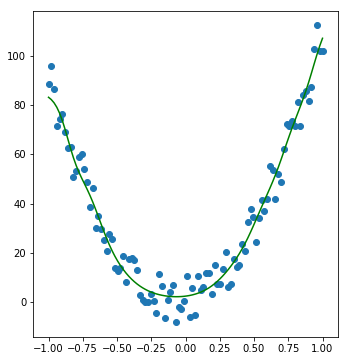

In [20]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [21]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [22]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 loss_train: 96.75801610 + 0.00000000 = 96.75801610 loss_val = 96.75801610
epoch:  100/1000 loss_train: 53.32719838 + 0.00000000 = 53.32719838 loss_val = 53.32719838
epoch:  200/1000 loss_train: 27.54641610 + 0.00000000 = 27.54641610 loss_val = 27.54641610
epoch:  300/1000 loss_train: 13.49313760 + 0.00000000 = 13.49313760 loss_val = 13.49313760
epoch:  400/1000 loss_train: 8.47935411 + 0.00000000 = 8.47935411 loss_val = 8.47935411
epoch:  500/1000 loss_train: 6.43684747 + 0.00000000 = 6.43684747 loss_val = 6.43684747
epoch:  600/1000 loss_train: 5.33765735 + 0.00000000 = 5.33765735 loss_val = 5.33765735
epoch:  700/1000 loss_train: 4.60419723 + 0.00000000 = 4.60419723 loss_val = 4.60419723
epoch:  800/1000 loss_train: 4.09673498 + 0.00000000 = 4.09673498 loss_val = 4.09673498
epoch:  900/1000 loss_train: 3.74204797 + 0.00000000 = 3.74204797 loss_val = 3.74204797
epoch: 1000/1000 loss_train: 3.48878440 + 0.00000000 = 3.48878440 loss_val = 3.48878440


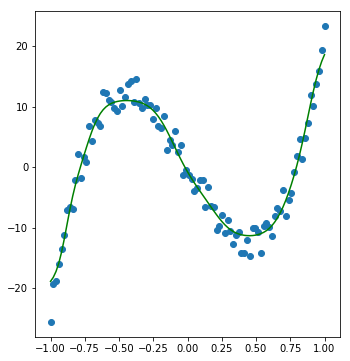

In [23]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [12]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [13]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 37191.81250905 + 0.00000000 = 37191.81250905 loss_val = 37191.81250905
epoch:  100/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  200/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  300/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  400/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  500/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  600/1000 loss_train: nan + nan = nan loss_val = nan


/Users/arnaldo/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  
/Users/arnaldo/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


epoch:  700/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  800/1000 loss_train: nan + nan = nan loss_val = nan
epoch:  900/1000 loss_train: nan + nan = nan loss_val = nan
epoch: 1000/1000 loss_train: nan + nan = nan loss_val = nan


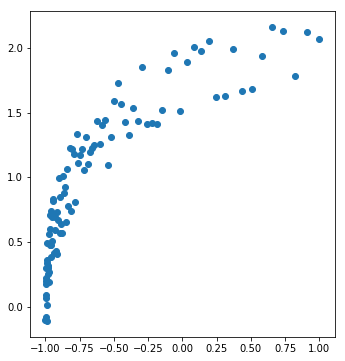

In [14]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1.0, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [27]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [28]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [ 1.]


epoch:    0/1000 loss_train: 2365.61181160 + 0.00000000 = 2365.61181160 loss_val = 2365.61181160
epoch:  100/1000 loss_train: 41.88717923 + 0.00000000 = 41.88717923 loss_val = 41.88717923
epoch:  200/1000 loss_train: 31.18558426 + 0.00000000 = 31.18558426 loss_val = 31.18558426
epoch:  300/1000 loss_train: 30.41583513 + 0.00000000 = 30.41583513 loss_val = 30.41583513
epoch:  400/1000 loss_train: 30.36400415 + 0.00000000 = 30.36400415 loss_val = 30.36400415
epoch:  500/1000 loss_train: 30.29909474 + 0.00000000 = 30.29909474 loss_val = 30.29909474
epoch:  600/1000 loss_train: 30.24736663 + 0.00000000 = 30.24736663 loss_val = 30.24736663
epoch:  700/1000 loss_train: 30.20551214 + 0.00000000 = 30.20551214 loss_val = 30.20551214
epoch:  800/1000 loss_train: 30.16219420 + 0.00000000 = 30.16219420 loss_val = 30.16219420
epoch:  900/1000 loss_train: 30.14122263 + 0.00000000 = 30.14122263 loss_val = 30.14122263
epoch: 1000/1000 loss_train: 30.10899567 + 0.00000000 = 30.10899567 loss_val = 30.10

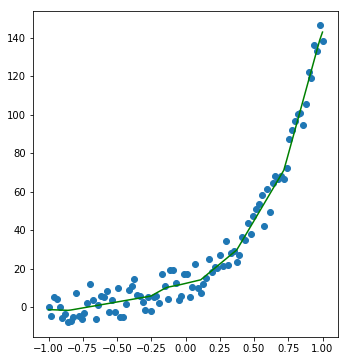

In [29]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-5, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [25]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/5000 loss_train: 0.92395675 + 0.07349084 = 0.99744759 loss_val = 0.92395675
epoch: 1000/5000 loss_train: 0.28642401 + 0.15234694 = 0.43877095 loss_val = 0.28642401
epoch: 2000/5000 loss_train: 0.28642398 + 0.15234696 = 0.43877094 loss_val = 0.28642398
epoch: 3000/5000 loss_train: 0.28642398 + 0.15234696 = 0.43877094 loss_val = 0.28642398
epoch: 4000/5000 loss_train: 0.28642398 + 0.15234696 = 0.43877094 loss_val = 0.28642398
epoch: 5000/5000 loss_train: 0.28642398 + 0.15234696 = 0.43877094 loss_val = 0.28642398
[[ 1.52346962  1.52346962]] [[-2.63959782]]
Predições:
[[ 0.06663304]
 [ 0.24673017]
 [ 0.24673017]
 [ 0.60045023]]
Acurácia: 100.00%


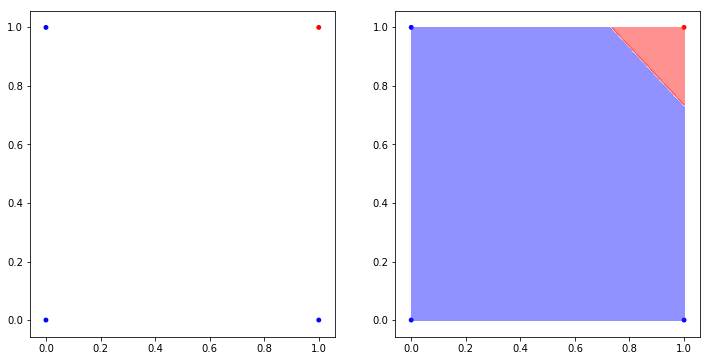

In [26]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=5000, verbose=1000)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Porta XOR

In [21]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.92352071 + 0.00000000 = 0.92352071 loss_val = 0.92352071
epoch:  100/1000 loss_train: 0.68947268 + 0.00000000 = 0.68947268 loss_val = 0.68947268
epoch:  200/1000 loss_train: 0.66986933 + 0.00000000 = 0.66986933 loss_val = 0.66986933
epoch:  300/1000 loss_train: 0.56722094 + 0.00000000 = 0.56722094 loss_val = 0.56722094
epoch:  400/1000 loss_train: 0.31094344 + 0.00000000 = 0.31094344 loss_val = 0.31094344
epoch:  500/1000 loss_train: 0.18139410 + 0.00000000 = 0.18139410 loss_val = 0.18139410
epoch:  600/1000 loss_train: 0.13191510 + 0.00000000 = 0.13191510 loss_val = 0.13191510
epoch:  700/1000 loss_train: 0.10647561 + 0.00000000 = 0.10647561 loss_val = 0.10647561
epoch:  800/1000 loss_train: 0.09083581 + 0.00000000 = 0.09083581 loss_val = 0.09083581
epoch:  900/1000 loss_train: 0.08013516 + 0.00000000 = 0.08013516 loss_val = 0.08013516
epoch: 1000/1000 loss_train: 0.07228496 + 0.00000000 = 0.07228496 loss_val = 0.07228496
Predições:
[[ 0.06780175]
 [ 0.9

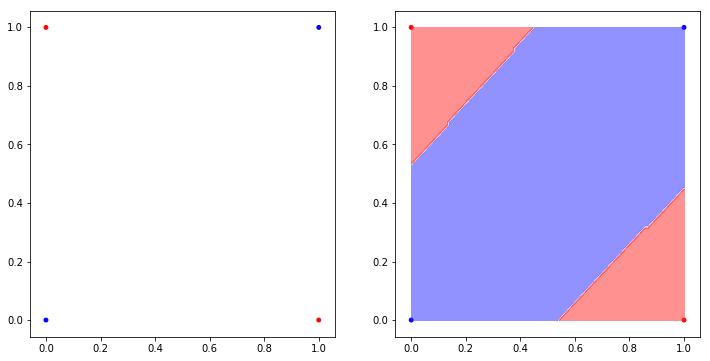

In [24]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 2 Clusters

In [34]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 loss_train: 2.81975247 + 0.00000000 = 2.81975247 loss_val = 2.81975247
epoch: 1000/5000 loss_train: 0.03872327 + 0.00000000 = 0.03872327 loss_val = 0.03872327
epoch: 2000/5000 loss_train: 0.02494136 + 0.00000000 = 0.02494136 loss_val = 0.02494136
epoch: 3000/5000 loss_train: 0.01955403 + 0.00000000 = 0.01955403 loss_val = 0.01955403
epoch: 4000/5000 loss_train: 0.01648964 + 0.00000000 = 0.01648964 loss_val = 0.01648964
epoch: 5000/5000 loss_train: 0.01445287 + 0.00000000 = 0.01445287 loss_val = 0.01445287
Acurácia: 100.00%


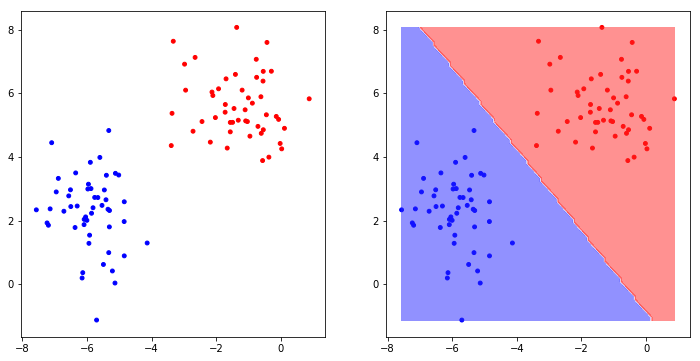

In [35]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### 4 Clusters

In [36]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 loss_train: 2.99779571 + 0.00000000 = 2.99779571 loss_val = 2.99779571
epoch:  100/500 loss_train: 0.05539317 + 0.00000000 = 0.05539317 loss_val = 0.05539317
epoch:  200/500 loss_train: 0.04259746 + 0.00000000 = 0.04259746 loss_val = 0.04259746
epoch:  300/500 loss_train: 0.03553537 + 0.00000000 = 0.03553537 loss_val = 0.03553537
epoch:  400/500 loss_train: 0.03094981 + 0.00000000 = 0.03094981 loss_val = 0.03094981
epoch:  500/500 loss_train: 0.02768445 + 0.00000000 = 0.02768445 loss_val = 0.02768445
Acurácia: 100.00%


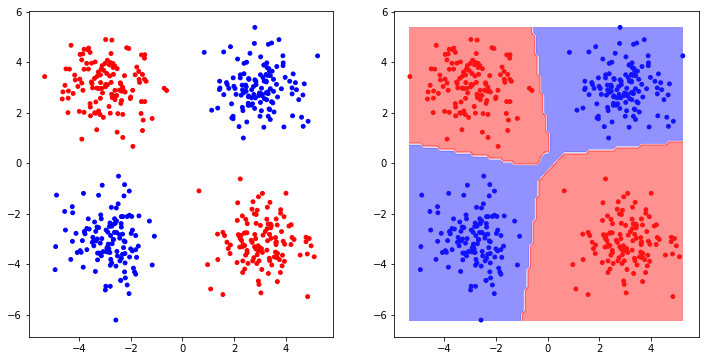

In [37]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [38]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 loss_train: 6.53566920 + 0.00000000 = 6.53566920 loss_val = 6.53566920
epoch:  100/1000 loss_train: 1.70348414 + 0.00000000 = 1.70348414 loss_val = 1.70348414
epoch:  200/1000 loss_train: 0.06123500 + 0.00000000 = 0.06123500 loss_val = 0.06123500
epoch:  300/1000 loss_train: 0.02425535 + 0.00000000 = 0.02425535 loss_val = 0.02425535
epoch:  400/1000 loss_train: 0.01693817 + 0.00000000 = 0.01693817 loss_val = 0.01693817
epoch:  500/1000 loss_train: 0.01297970 + 0.00000000 = 0.01297970 loss_val = 0.01297970
epoch:  600/1000 loss_train: 0.01059521 + 0.00000000 = 0.01059521 loss_val = 0.01059521
epoch:  700/1000 loss_train: 0.00899887 + 0.00000000 = 0.00899887 loss_val = 0.00899887
epoch:  800/1000 loss_train: 0.00784064 + 0.00000000 = 0.00784064 loss_val = 0.00784064
epoch:  900/1000 loss_train: 0.00698696 + 0.00000000 = 0.00698696 loss_val = 0.00698696
epoch: 1000/1000 loss_train: 0.00632486 + 0.00000000 = 0.00632486 loss_val = 0.00632486
Acurácia: 100.00%


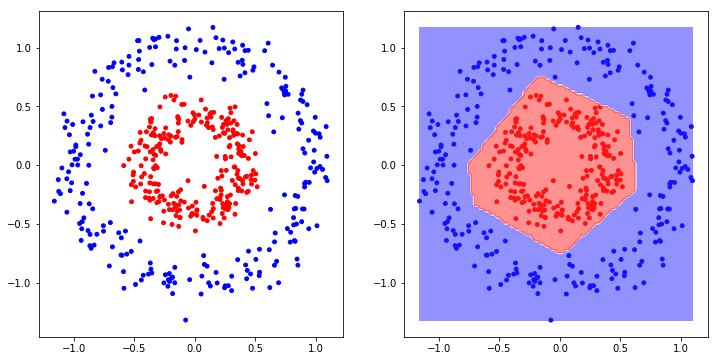

In [39]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [40]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 loss_train: 0.74203391 + 0.00000000 = 0.74203391 loss_val = 0.74203391
epoch:  200/2000 loss_train: 0.31967018 + 0.00000000 = 0.31967018 loss_val = 0.31967018
epoch:  400/2000 loss_train: 0.30311443 + 0.00000000 = 0.30311443 loss_val = 0.30311443
epoch:  600/2000 loss_train: 0.28703458 + 0.00000000 = 0.28703458 loss_val = 0.28703458
epoch:  800/2000 loss_train: 0.26996268 + 0.00000000 = 0.26996268 loss_val = 0.26996268
epoch: 1000/2000 loss_train: 0.23056093 + 0.00000000 = 0.23056093 loss_val = 0.23056093
epoch: 1200/2000 loss_train: 0.16849347 + 0.00000000 = 0.16849347 loss_val = 0.16849347
epoch: 1400/2000 loss_train: 0.12474786 + 0.00000000 = 0.12474786 loss_val = 0.12474786
epoch: 1600/2000 loss_train: 0.10018947 + 0.00000000 = 0.10018947 loss_val = 0.10018947
epoch: 1800/2000 loss_train: 0.08520877 + 0.00000000 = 0.08520877 loss_val = 0.08520877
epoch: 2000/2000 loss_train: 0.07511975 + 0.00000000 = 0.07511975 loss_val = 0.07511975
Acurácia: 99.00%


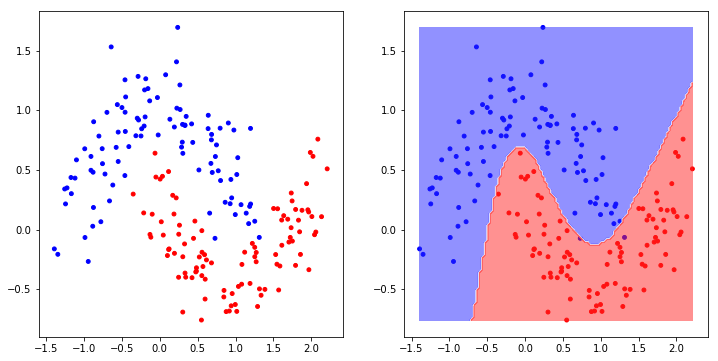

In [42]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [43]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 loss_train: 1.31713209 + 0.00000000 = 1.31713209 loss_val = 1.31713209
epoch:  500/5000 loss_train: 0.11718233 + 0.00000000 = 0.11718233 loss_val = 0.11718233
epoch: 1000/5000 loss_train: 0.04189723 + 0.00000000 = 0.04189723 loss_val = 0.04189723
epoch: 1500/5000 loss_train: 0.01780114 + 0.00000000 = 0.01780114 loss_val = 0.01780114
epoch: 2000/5000 loss_train: 0.02158732 + 0.00000000 = 0.02158732 loss_val = 0.02158732
epoch: 2500/5000 loss_train: 0.04544791 + 0.00000000 = 0.04544791 loss_val = 0.04544791
epoch: 3000/5000 loss_train: 0.01582253 + 0.00000000 = 0.01582253 loss_val = 0.01582253
epoch: 3500/5000 loss_train: 0.03336712 + 0.00000000 = 0.03336712 loss_val = 0.03336712
epoch: 4000/5000 loss_train: 0.02036389 + 0.00000000 = 0.02036389 loss_val = 0.02036389
epoch: 4500/5000 loss_train: 0.05505568 + 0.00000000 = 0.05505568 loss_val = 0.05505568
epoch: 5000/5000 loss_train: 0.01100687 + 0.00000000 = 0.01100687 loss_val = 0.01100687
Acurácia: 99.50%


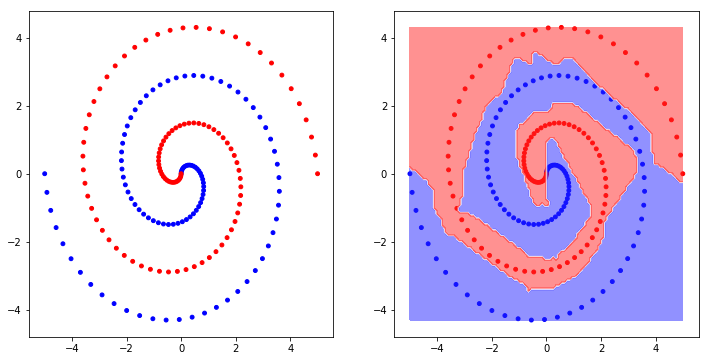

In [46]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=20, activation=tanh, dropout_prob=0.25))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [47]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [48]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]


epoch:    0/1000 loss_train: 2.59191657 + 0.32038857 = 2.91230513 loss_val = 2.59191657
epoch:  100/1000 loss_train: 0.37198377 + 0.14891911 = 0.52090288 loss_val = 0.37198377
epoch:  200/1000 loss_train: 0.32943035 + 0.13616956 = 0.46559991 loss_val = 0.32943035
epoch:  300/1000 loss_train: 0.29115090 + 0.13949558 = 0.43064648 loss_val = 0.29115090
epoch:  400/1000 loss_train: 0.26071506 + 0.14333477 = 0.40404984 loss_val = 0.26071506
epoch:  500/1000 loss_train: 0.23639865 + 0.14688868 = 0.38328733 loss_val = 0.23639865
epoch:  600/1000 loss_train: 0.21688118 + 0.14999811 = 0.36687929 loss_val = 0.21688118
epoch:  700/1000 loss_train: 0.20101796 + 0.15272700 = 0.35374495 loss_val = 0.20101796
epoch:  800/1000 loss_train: 0.18766041 + 0.15546551 = 0.34312592 loss_val = 0.18766041
epoch:  900/1000 loss_train: 0.17670077 + 0.15773244 = 0.33443321 loss_val = 0.17670077
epoch: 1000/1000 loss_train: 0.16775030 + 0.15944845 = 0.32719876 loss_val = 0.16775030
[[-0.03607156 -0.77810296]
 [-0.

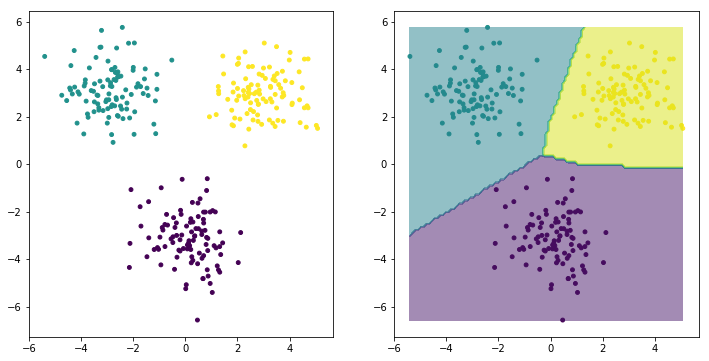

In [49]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [50]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [51]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


epoch:    0/1000 loss_train: 3.55038054 + 0.00000000 = 3.55038054 loss_val = 3.55038054
epoch:  100/1000 loss_train: 0.18409318 + 0.00000000 = 0.18409318 loss_val = 0.18409318
epoch:  200/1000 loss_train: 0.15210333 + 0.00000000 = 0.15210333 loss_val = 0.15210333
epoch:  300/1000 loss_train: 0.13670946 + 0.00000000 = 0.13670946 loss_val = 0.13670946
epoch:  400/1000 loss_train: 0.12359806 + 0.00000000 = 0.12359806 loss_val = 0.12359806
epoch:  500/1000 loss_train: 0.11400923 + 0.00000000 = 0.11400923 loss_val = 0.11400923
epoch:  600/1000 loss_train: 0.10676411 + 0.00000000 = 0.10676411 loss_val = 0.10676411
epoch:  700/1000 loss_train: 0.10075265 + 0.00000000 = 0.10075265 loss_val = 0.10075265
epoch:  800/1000 loss_train: 0.09655725 + 0.00000000 = 0.09655725 loss_val = 0.09655725
epoch:  900/1000 loss_train: 0.09329601 + 0.00000000 = 0.09329601 loss_val = 0.09329601
epoch: 1000/1000 loss_train: 0.09065479 + 0.00000000 = 0.09065479 loss_val = 0.09065479
Acurácia: 97.00%


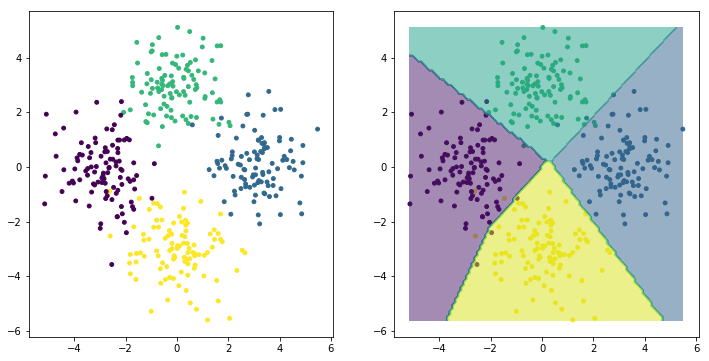

In [52]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [53]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [54]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


epoch:    0/1000 loss_train: 3.49162558 + 0.00000000 = 3.49162558 loss_val = 3.49162558
epoch:  100/1000 loss_train: 0.17685196 + 0.00000000 = 0.17685196 loss_val = 0.17685196
epoch:  200/1000 loss_train: 0.08391106 + 0.00000000 = 0.08391106 loss_val = 0.08391106
epoch:  300/1000 loss_train: 0.05973522 + 0.00000000 = 0.05973522 loss_val = 0.05973522
epoch:  400/1000 loss_train: 0.04800677 + 0.00000000 = 0.04800677 loss_val = 0.04800677
epoch:  500/1000 loss_train: 0.04161141 + 0.00000000 = 0.04161141 loss_val = 0.04161141
epoch:  600/1000 loss_train: 0.03748945 + 0.00000000 = 0.03748945 loss_val = 0.03748945
epoch:  700/1000 loss_train: 0.03459012 + 0.00000000 = 0.03459012 loss_val = 0.03459012
epoch:  800/1000 loss_train: 0.03242585 + 0.00000000 = 0.03242585 loss_val = 0.03242585
epoch:  900/1000 loss_train: 0.03071429 + 0.00000000 = 0.03071429 loss_val = 0.03071429
epoch: 1000/1000 loss_train: 0.02934379 + 0.00000000 = 0.02934379 loss_val = 0.02934379
Acurácia: 99.20%


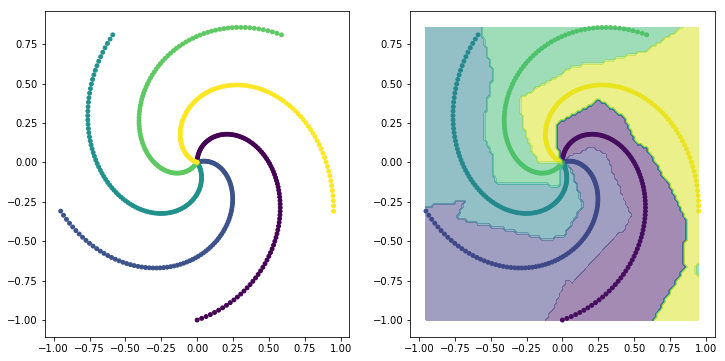

In [55]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [56]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [57]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  0.  0.  1.]]


epoch:    0/1000 loss_train: 6.66753577 + 0.00000000 = 6.66753577 loss_val = 6.66753577
epoch:  100/1000 loss_train: 0.38363488 + 0.00000000 = 0.38363488 loss_val = 0.38363488
epoch:  200/1000 loss_train: 0.33489762 + 0.00000000 = 0.33489762 loss_val = 0.33489762
epoch:  300/1000 loss_train: 0.31012605 + 0.00000000 = 0.31012605 loss_val = 0.31012605
epoch:  400/1000 loss_train: 0.29199269 + 0.00000000 = 0.29199269 loss_val = 0.29199269
epoch:  500/1000 loss_train: 0.27495321 + 0.00000000 = 0.27495321 loss_val = 0.27495321
epoch:  600/1000 loss_train: 0.25612527 + 0.00000000 = 0.25612527 loss_val = 0.25612527
epoch:  700/1000 loss_train: 0.24165824 + 0.00000000 = 0.24165824 loss_val = 0.24165824
epoch:  800/1000 loss_train: 0.22962015 + 0.00000000 = 0.22962015 loss_val = 0.22962015
epoch:  900/1000 loss_train: 0.21999736 + 0.00000000 = 0.21999736 loss_val = 0.21999736
epoch: 1000/1000 loss_train: 0.21128215 + 0.00000000 = 0.21128215 loss_val = 0.21128215
Acurácia: 94.00%


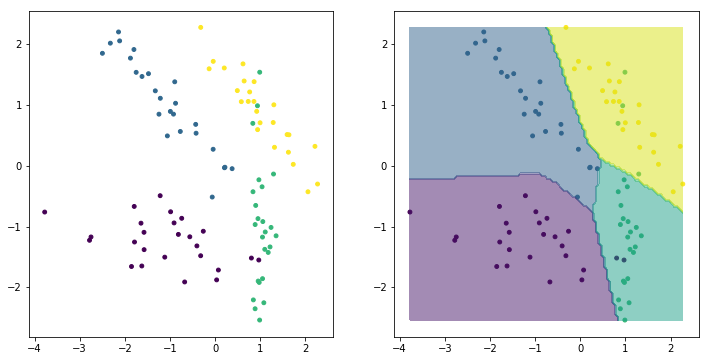

In [58]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [59]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [60]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


epoch:    0/5000 loss_train: 0.99802422 + 0.00000000 = 0.99802422 loss_val = 0.99802422
epoch:  500/5000 loss_train: 0.58637955 + 0.00000000 = 0.58637955 loss_val = 0.58637955
epoch: 1000/5000 loss_train: 0.46356942 + 0.00000000 = 0.46356942 loss_val = 0.46356942
epoch: 1500/5000 loss_train: 0.38187441 + 0.00000000 = 0.38187441 loss_val = 0.38187441
epoch: 2000/5000 loss_train: 0.32545681 + 0.00000000 = 0.32545681 loss_val = 0.32545681
epoch: 2500/5000 loss_train: 0.28448264 + 0.00000000 = 0.28448264 loss_val = 0.28448264
epoch: 3000/5000 loss_train: 0.25381146 + 0.00000000 = 0.25381146 loss_val = 0.25381146
epoch: 3500/5000 loss_train: 0.23025803 + 0.00000000 = 0.23025803 loss_val = 0.23025803
epoch: 4000/5000 loss_train: 0.21175382 + 0.00000000 = 0.21175382 loss_val = 0.21175382
epoch: 4500/5000 loss_train: 0.19691541 + 0.00000000 = 0.19691541 loss_val = 0.19691541
epoch: 5000/5000 loss_train: 0.18480296 + 0.00000000 = 0.18480296 loss_val = 0.18480296
Acurácia: 96.00%


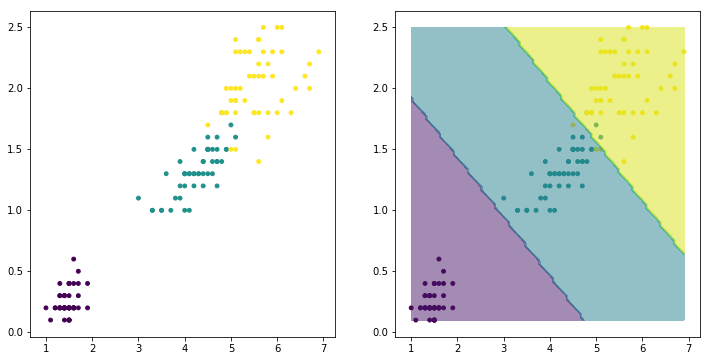

In [61]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-2, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=5000, verbose=500)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__TODO__:
- evitar overflow das funções de ativação
- early_stopping
- batch normalization

```py
def stablesoftmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)
```

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.

__Learning Rate Decay__:
- mostrar que a staircase_decay e exponential_decay tem praticamente a mesma fórmula, com exceção de decay_steps. Na própria documentação do Tensorflow, eles implementam as duas no mesmo método.